## Real-world example (MNIST ConvNet)

Here, we will train an extremely simple architecture of a convolutional network to classify MNIST digits. Next, you will have to build a more complex architecture to achieve better classification results.

In [1]:
import sys,os
import numpy as np
import matplotlib.pyplot as plt
import theano
import theano.tensor as T
import lasagne
import numpy as np
from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# ################## Download and prepare the MNIST dataset ##################
# This is just some way of getting the MNIST dataset from an online location
# and loading it into numpy arrays. It doesn't involve Lasagne at all.

def load_dataset():
    # We first define a download function, supporting both Python 2 and 3.
    if sys.version_info[0] == 2:
        from urllib import urlretrieve
    else:
        from urllib.request import urlretrieve
    dataset_path='nc17nn/datasets/'
    def download(filename, source='http://yann.lecun.com/exdb/mnist/'):
        print("Downloading %s" % filename)
        urlretrieve(source + filename, dataset_path + filename)

    # We then define functions for loading MNIST images and labels.
    # For convenience, they also download the requested files if needed.
    import gzip

    def load_mnist_images(filename):
        if not os.path.exists(dataset_path + filename):
            download(filename=filename)
        # Read the inputs in Yann LeCun's binary format.
        with gzip.open(dataset_path + filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
        # The inputs are vectors now, we reshape them to monochrome 2D images,
        # following the shape convention: (examples, channels, rows, columns)
        data = data.reshape(-1, 1, 28, 28)
        # The inputs come as bytes, we convert them to float32 in range [0,1].
        # (Actually to range [0, 255/256], for compatibility to the version
        # provided at http://deeplearning.net/data/mnist/mnist.pkl.gz.)
        return data / np.float32(256)

    def load_mnist_labels(filename):
        if not os.path.exists(dataset_path + filename):
            download(filename=filename)
        # Read the labels in Yann LeCun's binary format.
        with gzip.open(dataset_path + filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=8)
        # The labels are vectors of integers now, that's exactly what we want.
        return data

    # We can now download and read the training and test set images and labels.
    X_train = load_mnist_images('train-images-idx3-ubyte.gz')
    y_train = load_mnist_labels('train-labels-idx1-ubyte.gz')
    X_test = load_mnist_images('t10k-images-idx3-ubyte.gz')
    y_test = load_mnist_labels('t10k-labels-idx1-ubyte.gz')

    # We reserve the last 10000 training examples for validation.
    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]

    # We just return all the arrays in order, as expected in main().
    # (It doesn't matter how we do this as long as we can read them again.)
    return X_train, y_train, X_val, y_val, X_test, y_test

/home/teslah2o/Downloads/assignment_cnn/.env/local/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


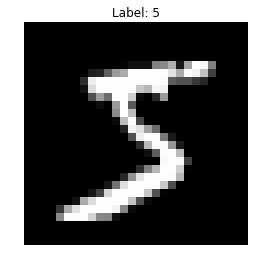

In [2]:
# We'll use the load_data function to load our train and test set (this can take a while)
X_train, y_train, X_valid, y_valid, X_test, y_test = load_dataset()
# Create a dataset dictionary for convenience
dataset = {
    'train': {'X': X_train, 'y': y_train},
    'valid': {'X': X_valid, 'y': y_valid}}
# Plot an example digit with its label
plt.imshow(dataset['train']['X'][0][0], interpolation='nearest', cmap=plt.cm.gray)
plt.title("Label: {}".format(dataset['train']['y'][0]))
plt.gca().set_axis_off()

### ConvNet Input

In `lasagne`, the convention for a 2D convolutional network is that the data's shape throughout the network is `(n_examples, n_channels, width, height)`.  Since MNIST digits has a single channel (they're grayscale images), `n_channels = 1` for the input layer; if we were dealing with RGB images we'd have `n_channels = 3`.  Within the network, `n_channels` is the number of filter kernels of each layer.

Conveniently, we can make the first dimension (the "number of example" dimension) variable.  This comes in handy when you pass your network training examples in minibatches, but want to evaluate the output on the entire validation or test set.  This is designated by setting the first entry of the shape passed to the `InputLayer` to `None`.

In [3]:
# We'll determine the input shape from the first example from the training set.
input_shape = dataset['train']['X'][0].shape
l_in = lasagne.layers.InputLayer(
    shape=(None, input_shape[0], input_shape[1], input_shape[2]))

### Convolutional layers

The basic 2D convolutional layer in Lasagne is `Conv2DLayer`.  This uses Theano's built-in convolution operation to convolve a collection 2D filter against the last two dimensions of its inputs. 

In [4]:
# Create the first convolutional layer
l_conv1 = lasagne.layers.Conv2DLayer(
    l_in,
    # Here, we set the number of filters and their size.
    num_filters=32, filter_size=(5, 5),
    # lasagne.nonlinearities.rectify is the common ReLU nonlinearity
    nonlinearity=lasagne.nonlinearities.rectify,
    # Use He et. al.'s initialization
    W=lasagne.init.HeNormal(gain='relu'))
# Other arguments: Convolution type (full, same, or valid) and stride

### Pooling layers

2D max pooling is straightforward: Use the `MaxPool2DLayer`.

In [5]:
# Here, we do 2x2 max pooling.  The max pooling layer also supports striding
l_pool1 = lasagne.layers.MaxPool2DLayer(l_conv1, pool_size=(2, 2))

### Dense layers

We'll be using a single hidden layer and a dense output layer.  As is the convention in convnets, the hidden layer will use a ReLU nonlinearity.

In [6]:
l_hidden1 = lasagne.layers.DenseLayer(
    l_pool1, num_units=256, 
    nonlinearity=lasagne.nonlinearities.rectify,
    W=lasagne.init.HeNormal(gain='relu'))

### Dropout

Dropout in Lasagne is implemented as a `Layer` subclass.  By placing a `DropoutLayer` between layers, the connections between the two layers will randomly be dropped.  As we'll see later, setting `get_output` or `get_loss`'s keyword argument `deterministic` to `True` will make the `DropoutLayer` act as a simple pass-through, which is useful when computing the output of the network after training.

In [7]:
# p is the dropout probability
l_hidden1_dropout = lasagne.layers.DropoutLayer(l_hidden1, p=0.5)

In [8]:
l_output = lasagne.layers.DenseLayer(
    l_hidden1_dropout,
    # The number of units in the softmax output layer is the number of classes.
    num_units=10,
    nonlinearity=lasagne.nonlinearities.softmax)

### Objectives, updates, and training

This part of the code will look very similar to above - we'll define an objective, compute some updates, use the updates to compile Theano functions, then use the functions to train the network and compute its output given some input.  Since this problem is a little harder than our toy example, we'll use ADADELTA, a fancier stochastic optimization technique, described in [ADADELTA: An Adaptive Learning Rate Method](http://arxiv.org/abs/1212.5701).  There's plenty of others to choose from in `lasagne.updates`.

In [17]:
net_output = lasagne.layers.get_output(l_output)
true_output = T.ivector('true_output')
loss = T.mean(lasagne.objectives.categorical_crossentropy(net_output, true_output))

# As mentioned above, when using dropout we should define different losses:
# One for training, one for evaluation.  The training loss should apply dropout,
# while the evaluation loss shouldn't.  This is controlled by setting get_output's deterministic kwarg.
loss_train = T.mean(lasagne.objectives.categorical_crossentropy(
        lasagne.layers.get_output(l_output, deterministic=False), true_output))
loss_eval = T.mean(lasagne.objectives.categorical_crossentropy(
        lasagne.layers.get_output(l_output, deterministic=True), true_output))

all_params = lasagne.layers.get_all_params(l_output)
# Use ADADELTA for updates
updates = lasagne.updates.adadelta(loss_train, all_params)
train = theano.function([l_in.input_var, true_output], loss_train, updates=updates)

# This is the function we'll use to compute the network's output given an input
# (e.g., for computing accuracy).  Again, we don't want to apply dropout here
# so we set the deterministic kwarg to True.
get_output = theano.function([l_in.input_var],
                             lasagne.layers.get_output(l_output, deterministic=True))

In [18]:
def train_cnn():
    # Now, let's train it!  We'll chop the training data into mini-batches,
    # and compute the validation accuracy every epoch.
    BATCH_SIZE = 100
    N_EPOCHS = 10
    # Keep track of which batch we're training with
    batch_idx = 0
    # Keep track of which epoch we're on
    epoch = 0
    while epoch < N_EPOCHS:
        # Extract the training data/label batch and update the parameters with it
        train(dataset['train']['X'][batch_idx:batch_idx + BATCH_SIZE],
              dataset['train']['y'][batch_idx:batch_idx + BATCH_SIZE])
        batch_idx += BATCH_SIZE
        # Once we've trained on the entire training set...
        if batch_idx >= dataset['train']['X'].shape[0]:
            # Reset the batch index
            batch_idx = 0
            # Update the number of epochs trained
            epoch += 1
            # Compute the network's output on the validation data
            val_output = get_output(dataset['valid']['X'])
            # The predicted class is just the index of the largest probability in the output
            val_predictions = np.argmax(val_output, axis=1)
            # The accuracy is the average number of correct predictions
            accuracy = np.mean(val_predictions == dataset['valid']['y'])
            print("Epoch {} validation accuracy: {}".format(epoch, accuracy))
    return accuracy

In [19]:
#Train and evaluate the simple CNN
accuracy_simple_cnn=train_cnn()

Epoch 1 validation accuracy: 0.9805
Epoch 2 validation accuracy: 0.9845
Epoch 3 validation accuracy: 0.9864
Epoch 4 validation accuracy: 0.987
Epoch 5 validation accuracy: 0.9881
Epoch 6 validation accuracy: 0.9875
Epoch 7 validation accuracy: 0.9866


KeyboardInterrupt: 

### Build a more complex architecture 

Now that you trained a simple CNN it is time for you to build a more complex architecture to achieve higher validation accuracy. You can use all the techniques you learned from the course: for their implementation in Lasagne take a look at library references at http://lasagne.readthedocs.io/en/latest/index.html

In [ ]:
#Build your network 
input_shape = dataset['train']['X'][0].shape
l_in = lasagne.layers.InputLayer(
    shape=(None, input_shape[0], input_shape[1], input_shape[2]))
l_conv1 = lasagne.layers.Conv2DLayer(
    l_in,
    num_filters=32, filter_size=(5, 5),
    nonlinearity=lasagne.nonlinearities.rectify,
    W=lasagne.init.HeNormal(gain='relu'))

l_pool1 = lasagne.layers.MaxPool2DLayer(l_conv1, pool_size=(2, 2))
#######################################################################################
#TODO add your layers
#######################################################################################

l_output = lasagne.layers.DenseLayer(
    l_last,
    num_units=10,
    nonlinearity=lasagne.nonlinearities.softmax)


In [ ]:
#Train and evaluate your network
net_output = lasagne.layers.get_output(l_output)
accuracy_customized_cnn=train_cnn()
print("Your network achieves {} of validation accuracy improvement".format(accuracy_customized_cnn-accuracy_simple_cnn))